# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

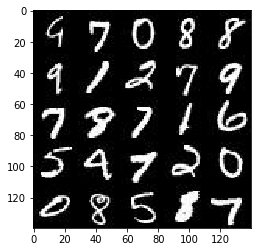

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

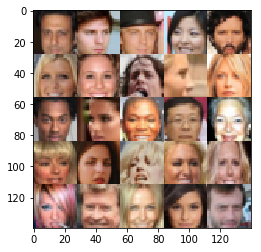

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, None)
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer shape is 28x28x3
        
        # Conv layer, resulting in 14x14x64
        tf.contrib.layers.convolution2d
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        # According to Matt's suggestion, do not use batch normalization in layer 1
        # Leaky relu
        x = tf.maximum(alpha * x, x)

        # Conv layer, resulting in 7x7x128
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding="same")
        # Batch normalization
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)

        # Conv layer, resulting in 4x4x256
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        # Conv layer, resulting in 2x2x512
        x = tf.layers.conv2d(x, 512, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        # Flattening layer
        flat = tf.contrib.layers.flatten(x) 
        logits = tf.layers.dense(flat, 1)    
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        # Input shape is 100
        
        # Fully connected layer, reshaped, batch normalized, with leaky relu, 
        # resulting in 2x2x512
        x = tf.layers.dense(z, 2*2*512) 
        x = tf.reshape(x, (-1, 2, 2, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        # Transposed convolutional layer, batch normalized, with leaky relu, 
        # resulting in 4x4x256
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        # Transposed convolutional layer, batch normalized, with leaky relu, 
        # resulting in 7x7x128
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=1, padding="valid")
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
                
        # Transposed convolutional layer, batch normalized, with leaky relu, 
        # resulting in 14x14x64
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        # Output layer, resulting in 28x28x5
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_labels_real = tf.ones_like(d_model_real) * 0.9 # Apply Label smoothing
    d_labels_fake = tf.zeros_like(d_model_fake)
    g_labels = tf.ones_like(d_model_fake)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_fake))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # 1) Variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    # 2) Update operations
    updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [update for update in updates if update.name.startswith("discriminator")]
    g_updates = [update for update in updates if update.name.startswith("generator")]

    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
            
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model                
                steps += 1
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # Run optimizer for generator twice to make sure that the discriminator loss does not go to zero
                for gen_opt_run in range(2):
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                # Get the losses and print them out
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator loss: {:.4f}...".format(train_loss_d),
                          "Generator loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator loss: 2.3951... Generator loss: 6.9419
Epoch 1/2... Discriminator loss: 1.4636... Generator loss: 2.0170
Epoch 1/2... Discriminator loss: 1.1489... Generator loss: 2.1879
Epoch 1/2... Discriminator loss: 1.1320... Generator loss: 1.6654
Epoch 1/2... Discriminator loss: 0.7824... Generator loss: 3.1036
Epoch 1/2... Discriminator loss: 1.2814... Generator loss: 1.1047
Epoch 1/2... Discriminator loss: 1.1109... Generator loss: 1.5143
Epoch 1/2... Discriminator loss: 1.1992... Generator loss: 1.5030
Epoch 1/2... Discriminator loss: 1.2529... Generator loss: 0.6122
Epoch 1/2... Discriminator loss: 1.5021... Generator loss: 0.4778


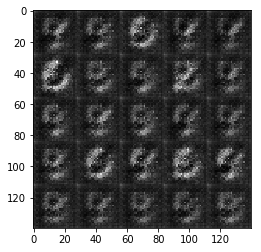

Epoch 1/2... Discriminator loss: 1.3410... Generator loss: 0.8210
Epoch 1/2... Discriminator loss: 1.2379... Generator loss: 0.9387
Epoch 1/2... Discriminator loss: 1.2718... Generator loss: 0.7393
Epoch 1/2... Discriminator loss: 1.3367... Generator loss: 0.5877
Epoch 1/2... Discriminator loss: 1.2125... Generator loss: 1.2537
Epoch 1/2... Discriminator loss: 1.3847... Generator loss: 0.8217
Epoch 1/2... Discriminator loss: 1.5025... Generator loss: 2.3713
Epoch 1/2... Discriminator loss: 1.2401... Generator loss: 0.9269
Epoch 1/2... Discriminator loss: 1.5203... Generator loss: 0.4113
Epoch 1/2... Discriminator loss: 1.3069... Generator loss: 0.6299


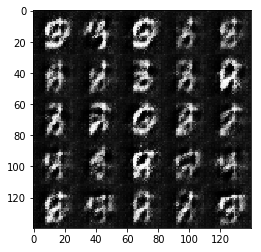

Epoch 1/2... Discriminator loss: 1.2504... Generator loss: 1.1002
Epoch 1/2... Discriminator loss: 1.2996... Generator loss: 0.6467
Epoch 1/2... Discriminator loss: 1.3617... Generator loss: 0.5080
Epoch 1/2... Discriminator loss: 1.1364... Generator loss: 1.0592
Epoch 1/2... Discriminator loss: 1.4041... Generator loss: 0.5619
Epoch 1/2... Discriminator loss: 1.2154... Generator loss: 0.7465
Epoch 1/2... Discriminator loss: 1.1409... Generator loss: 1.8091
Epoch 1/2... Discriminator loss: 1.4457... Generator loss: 1.9690
Epoch 1/2... Discriminator loss: 1.6795... Generator loss: 0.3517
Epoch 1/2... Discriminator loss: 1.2230... Generator loss: 1.1616


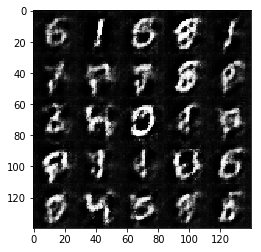

Epoch 1/2... Discriminator loss: 1.3473... Generator loss: 1.4027
Epoch 1/2... Discriminator loss: 1.3208... Generator loss: 0.6345
Epoch 1/2... Discriminator loss: 1.2951... Generator loss: 0.6472
Epoch 1/2... Discriminator loss: 1.2153... Generator loss: 0.9710
Epoch 1/2... Discriminator loss: 1.2358... Generator loss: 0.8009
Epoch 1/2... Discriminator loss: 1.2823... Generator loss: 0.8544
Epoch 1/2... Discriminator loss: 1.3434... Generator loss: 0.5913
Epoch 1/2... Discriminator loss: 1.1812... Generator loss: 0.9269
Epoch 1/2... Discriminator loss: 1.2379... Generator loss: 1.0288
Epoch 1/2... Discriminator loss: 1.3618... Generator loss: 1.7238


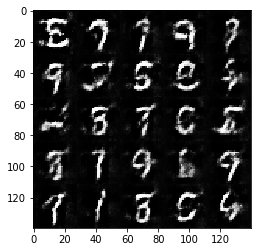

Epoch 1/2... Discriminator loss: 1.2738... Generator loss: 0.6876
Epoch 1/2... Discriminator loss: 1.4733... Generator loss: 1.6051
Epoch 1/2... Discriminator loss: 1.3948... Generator loss: 0.5950
Epoch 1/2... Discriminator loss: 1.3347... Generator loss: 1.0812
Epoch 1/2... Discriminator loss: 1.2673... Generator loss: 0.7975
Epoch 1/2... Discriminator loss: 1.2077... Generator loss: 0.8222
Epoch 1/2... Discriminator loss: 1.5587... Generator loss: 0.3986
Epoch 1/2... Discriminator loss: 1.4481... Generator loss: 1.7044
Epoch 1/2... Discriminator loss: 1.2038... Generator loss: 0.9731
Epoch 1/2... Discriminator loss: 1.7653... Generator loss: 0.3086


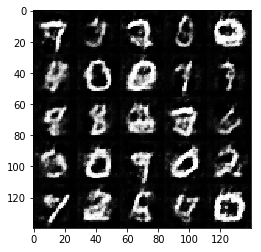

Epoch 1/2... Discriminator loss: 1.3608... Generator loss: 0.7382
Epoch 1/2... Discriminator loss: 1.3759... Generator loss: 0.5527
Epoch 1/2... Discriminator loss: 1.1468... Generator loss: 1.1196
Epoch 1/2... Discriminator loss: 1.6753... Generator loss: 0.3351
Epoch 1/2... Discriminator loss: 1.3525... Generator loss: 0.6865
Epoch 1/2... Discriminator loss: 1.3271... Generator loss: 1.3091
Epoch 1/2... Discriminator loss: 1.4949... Generator loss: 0.4513
Epoch 1/2... Discriminator loss: 1.3821... Generator loss: 0.6808
Epoch 1/2... Discriminator loss: 1.3130... Generator loss: 0.6780
Epoch 1/2... Discriminator loss: 1.7262... Generator loss: 0.3201


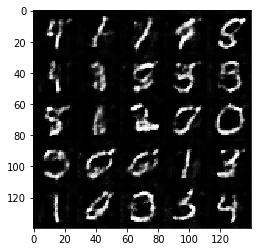

Epoch 1/2... Discriminator loss: 1.3931... Generator loss: 0.5269
Epoch 1/2... Discriminator loss: 1.2242... Generator loss: 0.6549
Epoch 1/2... Discriminator loss: 1.3902... Generator loss: 0.6182
Epoch 1/2... Discriminator loss: 1.3194... Generator loss: 0.5729
Epoch 1/2... Discriminator loss: 1.7119... Generator loss: 0.3206
Epoch 1/2... Discriminator loss: 1.4442... Generator loss: 0.4942
Epoch 1/2... Discriminator loss: 1.1902... Generator loss: 0.7955
Epoch 1/2... Discriminator loss: 2.0923... Generator loss: 1.7711
Epoch 1/2... Discriminator loss: 1.2804... Generator loss: 0.6336
Epoch 1/2... Discriminator loss: 1.6092... Generator loss: 1.5075


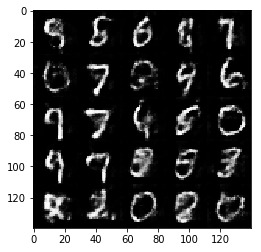

Epoch 1/2... Discriminator loss: 1.6230... Generator loss: 0.3712
Epoch 1/2... Discriminator loss: 1.6010... Generator loss: 0.8171
Epoch 1/2... Discriminator loss: 1.1997... Generator loss: 0.7357
Epoch 1/2... Discriminator loss: 1.2493... Generator loss: 0.6623
Epoch 1/2... Discriminator loss: 1.1929... Generator loss: 0.6768
Epoch 1/2... Discriminator loss: 2.0058... Generator loss: 0.2376
Epoch 1/2... Discriminator loss: 1.2391... Generator loss: 0.7138
Epoch 1/2... Discriminator loss: 1.0064... Generator loss: 1.2314
Epoch 1/2... Discriminator loss: 1.2203... Generator loss: 0.6487
Epoch 1/2... Discriminator loss: 1.4869... Generator loss: 0.4607


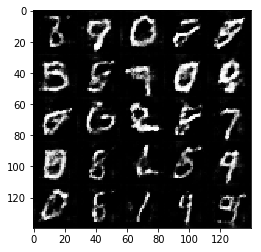

Epoch 1/2... Discriminator loss: 1.2487... Generator loss: 1.3526
Epoch 1/2... Discriminator loss: 1.4295... Generator loss: 0.5360
Epoch 1/2... Discriminator loss: 1.1958... Generator loss: 0.8476
Epoch 1/2... Discriminator loss: 1.7989... Generator loss: 0.2862
Epoch 1/2... Discriminator loss: 1.3467... Generator loss: 0.5724
Epoch 1/2... Discriminator loss: 2.3864... Generator loss: 0.1660
Epoch 1/2... Discriminator loss: 1.5136... Generator loss: 0.4022
Epoch 1/2... Discriminator loss: 1.7001... Generator loss: 0.3236
Epoch 1/2... Discriminator loss: 1.4258... Generator loss: 0.4450
Epoch 1/2... Discriminator loss: 1.1557... Generator loss: 0.8061


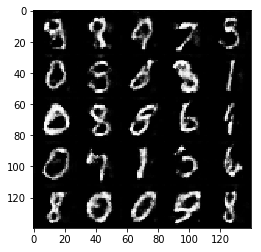

Epoch 1/2... Discriminator loss: 1.3127... Generator loss: 0.8279
Epoch 1/2... Discriminator loss: 1.1547... Generator loss: 0.7409
Epoch 1/2... Discriminator loss: 1.5906... Generator loss: 0.3826
Epoch 2/2... Discriminator loss: 1.4027... Generator loss: 1.5700
Epoch 2/2... Discriminator loss: 1.3442... Generator loss: 0.8442
Epoch 2/2... Discriminator loss: 1.1943... Generator loss: 1.4375
Epoch 2/2... Discriminator loss: 1.4470... Generator loss: 0.4509
Epoch 2/2... Discriminator loss: 2.1752... Generator loss: 0.2007
Epoch 2/2... Discriminator loss: 1.4745... Generator loss: 0.4602
Epoch 2/2... Discriminator loss: 1.5313... Generator loss: 0.4092


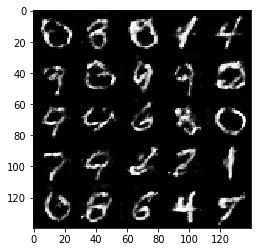

Epoch 2/2... Discriminator loss: 1.7518... Generator loss: 0.3263
Epoch 2/2... Discriminator loss: 1.6088... Generator loss: 0.3581
Epoch 2/2... Discriminator loss: 1.0612... Generator loss: 1.1379
Epoch 2/2... Discriminator loss: 1.3662... Generator loss: 0.5103
Epoch 2/2... Discriminator loss: 1.6673... Generator loss: 0.3834
Epoch 2/2... Discriminator loss: 1.4997... Generator loss: 0.5604
Epoch 2/2... Discriminator loss: 1.3346... Generator loss: 0.5041
Epoch 2/2... Discriminator loss: 0.8523... Generator loss: 1.2727
Epoch 2/2... Discriminator loss: 1.8062... Generator loss: 0.3049
Epoch 2/2... Discriminator loss: 2.0686... Generator loss: 0.2276


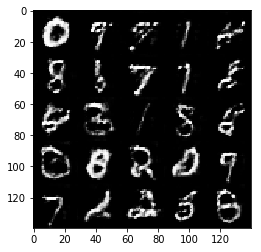

Epoch 2/2... Discriminator loss: 1.4914... Generator loss: 0.4296
Epoch 2/2... Discriminator loss: 1.1131... Generator loss: 1.5560
Epoch 2/2... Discriminator loss: 1.2030... Generator loss: 1.4477
Epoch 2/2... Discriminator loss: 1.1540... Generator loss: 0.7106
Epoch 2/2... Discriminator loss: 1.5601... Generator loss: 1.7588
Epoch 2/2... Discriminator loss: 1.3830... Generator loss: 0.5499
Epoch 2/2... Discriminator loss: 1.3816... Generator loss: 0.5143
Epoch 2/2... Discriminator loss: 1.2901... Generator loss: 0.8638
Epoch 2/2... Discriminator loss: 1.6832... Generator loss: 0.3526
Epoch 2/2... Discriminator loss: 1.2211... Generator loss: 1.6242


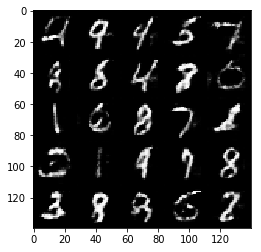

Epoch 2/2... Discriminator loss: 0.9536... Generator loss: 1.0712
Epoch 2/2... Discriminator loss: 1.9616... Generator loss: 0.2781
Epoch 2/2... Discriminator loss: 1.1922... Generator loss: 0.7512
Epoch 2/2... Discriminator loss: 0.9279... Generator loss: 1.0955
Epoch 2/2... Discriminator loss: 0.9617... Generator loss: 0.9154
Epoch 2/2... Discriminator loss: 2.1671... Generator loss: 0.2097
Epoch 2/2... Discriminator loss: 1.1167... Generator loss: 0.7984
Epoch 2/2... Discriminator loss: 1.2923... Generator loss: 0.5936
Epoch 2/2... Discriminator loss: 2.0995... Generator loss: 0.2289
Epoch 2/2... Discriminator loss: 1.4337... Generator loss: 0.4675


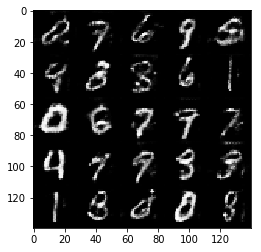

Epoch 2/2... Discriminator loss: 2.0181... Generator loss: 0.2276
Epoch 2/2... Discriminator loss: 1.0085... Generator loss: 0.8151
Epoch 2/2... Discriminator loss: 2.4980... Generator loss: 0.1603
Epoch 2/2... Discriminator loss: 1.6475... Generator loss: 0.3556
Epoch 2/2... Discriminator loss: 1.3306... Generator loss: 0.5330
Epoch 2/2... Discriminator loss: 1.5432... Generator loss: 0.4053
Epoch 2/2... Discriminator loss: 1.1448... Generator loss: 1.0656
Epoch 2/2... Discriminator loss: 1.5400... Generator loss: 0.4041
Epoch 2/2... Discriminator loss: 1.3427... Generator loss: 0.5248
Epoch 2/2... Discriminator loss: 1.9514... Generator loss: 2.0106


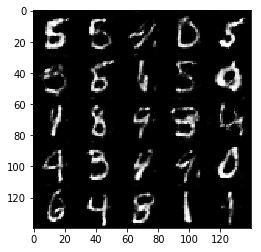

Epoch 2/2... Discriminator loss: 1.3074... Generator loss: 0.5513
Epoch 2/2... Discriminator loss: 0.8460... Generator loss: 1.7650
Epoch 2/2... Discriminator loss: 2.4201... Generator loss: 0.1742
Epoch 2/2... Discriminator loss: 1.8524... Generator loss: 0.3814
Epoch 2/2... Discriminator loss: 0.8948... Generator loss: 1.0673
Epoch 2/2... Discriminator loss: 1.1648... Generator loss: 1.3542
Epoch 2/2... Discriminator loss: 1.8860... Generator loss: 0.3637
Epoch 2/2... Discriminator loss: 0.9913... Generator loss: 0.8216
Epoch 2/2... Discriminator loss: 1.6008... Generator loss: 0.3958
Epoch 2/2... Discriminator loss: 1.6925... Generator loss: 0.3825


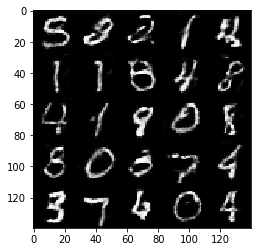

Epoch 2/2... Discriminator loss: 1.5030... Generator loss: 0.4491
Epoch 2/2... Discriminator loss: 1.2918... Generator loss: 0.7567
Epoch 2/2... Discriminator loss: 1.0765... Generator loss: 1.0560
Epoch 2/2... Discriminator loss: 1.2060... Generator loss: 0.6287
Epoch 2/2... Discriminator loss: 1.1244... Generator loss: 1.4548
Epoch 2/2... Discriminator loss: 1.8948... Generator loss: 0.2743
Epoch 2/2... Discriminator loss: 1.2705... Generator loss: 0.5501
Epoch 2/2... Discriminator loss: 1.3633... Generator loss: 0.5089
Epoch 2/2... Discriminator loss: 1.2652... Generator loss: 0.9140
Epoch 2/2... Discriminator loss: 1.3631... Generator loss: 0.5386


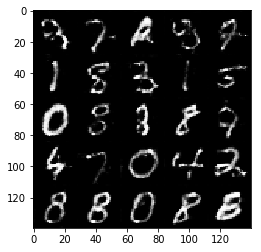

Epoch 2/2... Discriminator loss: 1.2040... Generator loss: 0.6918
Epoch 2/2... Discriminator loss: 0.9834... Generator loss: 0.9453
Epoch 2/2... Discriminator loss: 1.4675... Generator loss: 0.4619
Epoch 2/2... Discriminator loss: 1.8282... Generator loss: 0.3190
Epoch 2/2... Discriminator loss: 1.7808... Generator loss: 0.2981
Epoch 2/2... Discriminator loss: 2.2412... Generator loss: 0.1909
Epoch 2/2... Discriminator loss: 1.8134... Generator loss: 0.3048
Epoch 2/2... Discriminator loss: 1.6839... Generator loss: 0.3406
Epoch 2/2... Discriminator loss: 1.2245... Generator loss: 0.6529
Epoch 2/2... Discriminator loss: 0.9143... Generator loss: 0.9944


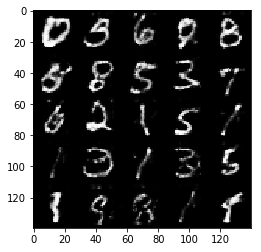

Epoch 2/2... Discriminator loss: 1.1921... Generator loss: 0.6731
Epoch 2/2... Discriminator loss: 1.6776... Generator loss: 0.3611
Epoch 2/2... Discriminator loss: 1.3182... Generator loss: 0.5981
Epoch 2/2... Discriminator loss: 1.2080... Generator loss: 0.6337
Epoch 2/2... Discriminator loss: 1.5470... Generator loss: 0.4127
Epoch 2/2... Discriminator loss: 1.0363... Generator loss: 0.7964
Epoch 2/2... Discriminator loss: 1.7979... Generator loss: 0.3624
Epoch 2/2... Discriminator loss: 1.2818... Generator loss: 0.5465
Epoch 2/2... Discriminator loss: 1.1637... Generator loss: 0.7444
Epoch 2/2... Discriminator loss: 0.9219... Generator loss: 2.1996


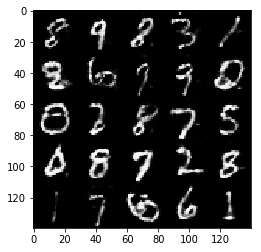

Epoch 2/2... Discriminator loss: 1.8092... Generator loss: 0.3140
Epoch 2/2... Discriminator loss: 1.9849... Generator loss: 0.2711
Epoch 2/2... Discriminator loss: 1.4047... Generator loss: 0.4680
Epoch 2/2... Discriminator loss: 0.9318... Generator loss: 1.1312
Epoch 2/2... Discriminator loss: 1.4807... Generator loss: 2.3638
Epoch 2/2... Discriminator loss: 0.9654... Generator loss: 0.9602
Epoch 2/2... Discriminator loss: 0.9949... Generator loss: 1.2896


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator loss: 1.9745... Generator loss: 6.5924
Epoch 1/1... Discriminator loss: 3.6773... Generator loss: 0.0394
Epoch 1/1... Discriminator loss: 1.4860... Generator loss: 5.9560
Epoch 1/1... Discriminator loss: 1.7019... Generator loss: 0.9191
Epoch 1/1... Discriminator loss: 1.5851... Generator loss: 0.9547
Epoch 1/1... Discriminator loss: 1.6732... Generator loss: 0.4385
Epoch 1/1... Discriminator loss: 1.5501... Generator loss: 0.6353
Epoch 1/1... Discriminator loss: 1.2790... Generator loss: 1.0417
Epoch 1/1... Discriminator loss: 1.8491... Generator loss: 0.6353
Epoch 1/1... Discriminator loss: 1.5044... Generator loss: 0.6729


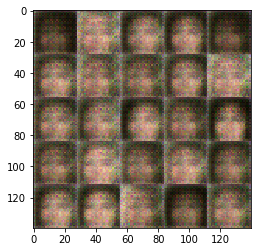

Epoch 1/1... Discriminator loss: 1.2767... Generator loss: 0.8068
Epoch 1/1... Discriminator loss: 1.3306... Generator loss: 0.7050
Epoch 1/1... Discriminator loss: 1.4610... Generator loss: 0.7510
Epoch 1/1... Discriminator loss: 1.5568... Generator loss: 0.5108
Epoch 1/1... Discriminator loss: 1.6366... Generator loss: 0.7633
Epoch 1/1... Discriminator loss: 1.3000... Generator loss: 0.7906
Epoch 1/1... Discriminator loss: 1.4846... Generator loss: 0.7528
Epoch 1/1... Discriminator loss: 1.5310... Generator loss: 0.6170
Epoch 1/1... Discriminator loss: 1.3299... Generator loss: 0.7228
Epoch 1/1... Discriminator loss: 1.3580... Generator loss: 0.7440


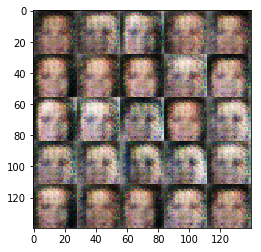

Epoch 1/1... Discriminator loss: 1.5378... Generator loss: 0.6218
Epoch 1/1... Discriminator loss: 1.4810... Generator loss: 0.6899
Epoch 1/1... Discriminator loss: 1.4055... Generator loss: 0.7271
Epoch 1/1... Discriminator loss: 1.3485... Generator loss: 0.7359
Epoch 1/1... Discriminator loss: 1.2216... Generator loss: 0.9625
Epoch 1/1... Discriminator loss: 1.5461... Generator loss: 0.7257
Epoch 1/1... Discriminator loss: 1.4057... Generator loss: 0.9202
Epoch 1/1... Discriminator loss: 1.4525... Generator loss: 0.6662
Epoch 1/1... Discriminator loss: 1.3662... Generator loss: 0.8014
Epoch 1/1... Discriminator loss: 1.4214... Generator loss: 0.7318


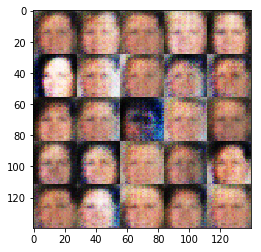

Epoch 1/1... Discriminator loss: 1.4123... Generator loss: 0.7797
Epoch 1/1... Discriminator loss: 1.3528... Generator loss: 0.7726
Epoch 1/1... Discriminator loss: 1.5178... Generator loss: 0.7016
Epoch 1/1... Discriminator loss: 1.3791... Generator loss: 0.8081
Epoch 1/1... Discriminator loss: 1.4539... Generator loss: 0.7968
Epoch 1/1... Discriminator loss: 1.4057... Generator loss: 0.7777
Epoch 1/1... Discriminator loss: 1.4065... Generator loss: 0.7412
Epoch 1/1... Discriminator loss: 1.4487... Generator loss: 0.7067
Epoch 1/1... Discriminator loss: 1.4928... Generator loss: 0.8076
Epoch 1/1... Discriminator loss: 1.3903... Generator loss: 0.7478


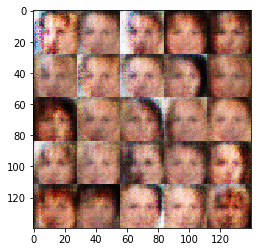

Epoch 1/1... Discriminator loss: 1.4125... Generator loss: 0.7451
Epoch 1/1... Discriminator loss: 1.3988... Generator loss: 0.7416
Epoch 1/1... Discriminator loss: 1.3847... Generator loss: 0.7466
Epoch 1/1... Discriminator loss: 1.4452... Generator loss: 0.7272
Epoch 1/1... Discriminator loss: 1.3795... Generator loss: 0.7640
Epoch 1/1... Discriminator loss: 1.4446... Generator loss: 0.7665
Epoch 1/1... Discriminator loss: 1.4888... Generator loss: 0.6923
Epoch 1/1... Discriminator loss: 1.4001... Generator loss: 0.7850
Epoch 1/1... Discriminator loss: 1.3471... Generator loss: 0.7851
Epoch 1/1... Discriminator loss: 1.3945... Generator loss: 0.7633


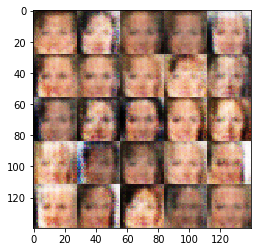

Epoch 1/1... Discriminator loss: 1.3672... Generator loss: 0.7879
Epoch 1/1... Discriminator loss: 1.4017... Generator loss: 0.7948
Epoch 1/1... Discriminator loss: 1.4224... Generator loss: 0.7313
Epoch 1/1... Discriminator loss: 1.3707... Generator loss: 0.7705
Epoch 1/1... Discriminator loss: 1.3477... Generator loss: 0.7876
Epoch 1/1... Discriminator loss: 1.3829... Generator loss: 0.7779
Epoch 1/1... Discriminator loss: 1.4659... Generator loss: 0.6983
Epoch 1/1... Discriminator loss: 1.3426... Generator loss: 0.8024
Epoch 1/1... Discriminator loss: 1.3253... Generator loss: 0.8097
Epoch 1/1... Discriminator loss: 1.3601... Generator loss: 0.7732


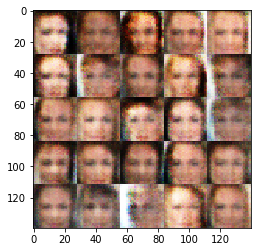

Epoch 1/1... Discriminator loss: 1.3608... Generator loss: 0.7964
Epoch 1/1... Discriminator loss: 1.3896... Generator loss: 0.7773
Epoch 1/1... Discriminator loss: 1.3385... Generator loss: 0.8103
Epoch 1/1... Discriminator loss: 1.3592... Generator loss: 0.7936
Epoch 1/1... Discriminator loss: 1.3635... Generator loss: 0.7774
Epoch 1/1... Discriminator loss: 1.3777... Generator loss: 0.7808
Epoch 1/1... Discriminator loss: 1.3926... Generator loss: 0.7503
Epoch 1/1... Discriminator loss: 1.3901... Generator loss: 0.7404
Epoch 1/1... Discriminator loss: 1.4053... Generator loss: 0.7525
Epoch 1/1... Discriminator loss: 1.4084... Generator loss: 0.7849


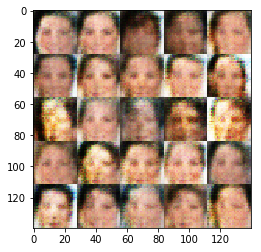

Epoch 1/1... Discriminator loss: 1.3435... Generator loss: 0.8471
Epoch 1/1... Discriminator loss: 1.3342... Generator loss: 0.8060
Epoch 1/1... Discriminator loss: 1.3922... Generator loss: 0.7355
Epoch 1/1... Discriminator loss: 1.3731... Generator loss: 0.7712
Epoch 1/1... Discriminator loss: 1.3674... Generator loss: 0.8077
Epoch 1/1... Discriminator loss: 1.3982... Generator loss: 0.7723
Epoch 1/1... Discriminator loss: 1.3714... Generator loss: 0.7761
Epoch 1/1... Discriminator loss: 1.4001... Generator loss: 0.7555
Epoch 1/1... Discriminator loss: 1.3613... Generator loss: 0.7761
Epoch 1/1... Discriminator loss: 1.3926... Generator loss: 0.7889


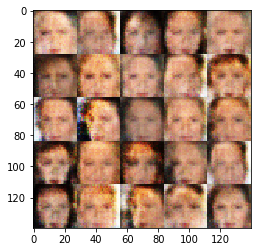

Epoch 1/1... Discriminator loss: 1.3696... Generator loss: 0.7894
Epoch 1/1... Discriminator loss: 1.3399... Generator loss: 0.7943
Epoch 1/1... Discriminator loss: 1.3575... Generator loss: 0.7691
Epoch 1/1... Discriminator loss: 1.3582... Generator loss: 0.8138
Epoch 1/1... Discriminator loss: 1.3544... Generator loss: 0.8027
Epoch 1/1... Discriminator loss: 1.3555... Generator loss: 0.7576
Epoch 1/1... Discriminator loss: 1.3376... Generator loss: 0.7758
Epoch 1/1... Discriminator loss: 1.3888... Generator loss: 0.7536
Epoch 1/1... Discriminator loss: 1.3373... Generator loss: 0.7903
Epoch 1/1... Discriminator loss: 1.3234... Generator loss: 0.8086


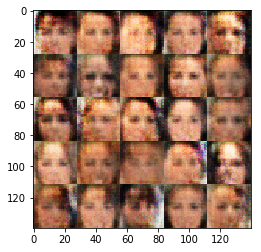

Epoch 1/1... Discriminator loss: 1.4164... Generator loss: 0.7565
Epoch 1/1... Discriminator loss: 1.3659... Generator loss: 0.7911
Epoch 1/1... Discriminator loss: 1.3829... Generator loss: 0.7678
Epoch 1/1... Discriminator loss: 1.3751... Generator loss: 0.7580
Epoch 1/1... Discriminator loss: 1.3795... Generator loss: 0.7542
Epoch 1/1... Discriminator loss: 1.3975... Generator loss: 0.7463
Epoch 1/1... Discriminator loss: 1.3831... Generator loss: 0.7494
Epoch 1/1... Discriminator loss: 1.3707... Generator loss: 0.8395
Epoch 1/1... Discriminator loss: 1.3797... Generator loss: 0.7652
Epoch 1/1... Discriminator loss: 1.3805... Generator loss: 0.7567


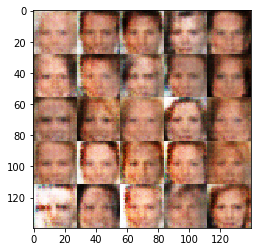

Epoch 1/1... Discriminator loss: 1.3709... Generator loss: 0.8007
Epoch 1/1... Discriminator loss: 1.3883... Generator loss: 0.7306
Epoch 1/1... Discriminator loss: 1.4006... Generator loss: 0.7413
Epoch 1/1... Discriminator loss: 1.4093... Generator loss: 0.7612
Epoch 1/1... Discriminator loss: 1.4042... Generator loss: 0.7891
Epoch 1/1... Discriminator loss: 1.3993... Generator loss: 0.7655
Epoch 1/1... Discriminator loss: 1.4100... Generator loss: 0.7162
Epoch 1/1... Discriminator loss: 1.4079... Generator loss: 0.7459
Epoch 1/1... Discriminator loss: 1.3543... Generator loss: 0.7899
Epoch 1/1... Discriminator loss: 1.3900... Generator loss: 0.7609


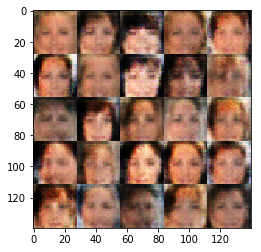

Epoch 1/1... Discriminator loss: 1.3951... Generator loss: 0.7287
Epoch 1/1... Discriminator loss: 1.3650... Generator loss: 0.7702
Epoch 1/1... Discriminator loss: 1.3604... Generator loss: 0.8212
Epoch 1/1... Discriminator loss: 1.3749... Generator loss: 0.7818
Epoch 1/1... Discriminator loss: 1.3831... Generator loss: 0.7604
Epoch 1/1... Discriminator loss: 1.3677... Generator loss: 0.7868
Epoch 1/1... Discriminator loss: 1.3871... Generator loss: 0.7686
Epoch 1/1... Discriminator loss: 1.3779... Generator loss: 0.7627
Epoch 1/1... Discriminator loss: 1.3526... Generator loss: 0.7756
Epoch 1/1... Discriminator loss: 1.4126... Generator loss: 0.7437


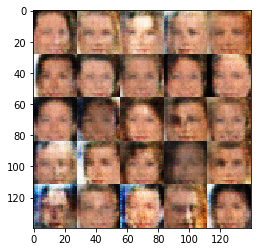

Epoch 1/1... Discriminator loss: 1.3635... Generator loss: 0.8000
Epoch 1/1... Discriminator loss: 1.4142... Generator loss: 0.7106
Epoch 1/1... Discriminator loss: 1.3803... Generator loss: 0.8146
Epoch 1/1... Discriminator loss: 1.3607... Generator loss: 0.7871
Epoch 1/1... Discriminator loss: 1.3666... Generator loss: 0.7630
Epoch 1/1... Discriminator loss: 1.4376... Generator loss: 0.7058
Epoch 1/1... Discriminator loss: 1.3711... Generator loss: 0.7625
Epoch 1/1... Discriminator loss: 1.3633... Generator loss: 0.7687
Epoch 1/1... Discriminator loss: 1.3679... Generator loss: 0.7837
Epoch 1/1... Discriminator loss: 1.3685... Generator loss: 0.7597


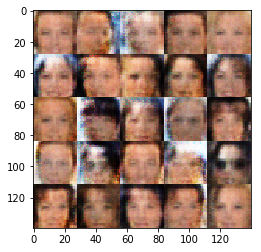

Epoch 1/1... Discriminator loss: 1.4008... Generator loss: 0.7528
Epoch 1/1... Discriminator loss: 1.3626... Generator loss: 0.7691
Epoch 1/1... Discriminator loss: 1.3422... Generator loss: 0.7853
Epoch 1/1... Discriminator loss: 1.4217... Generator loss: 0.7335
Epoch 1/1... Discriminator loss: 1.4140... Generator loss: 0.7675
Epoch 1/1... Discriminator loss: 1.4015... Generator loss: 0.7401
Epoch 1/1... Discriminator loss: 1.3938... Generator loss: 0.7414
Epoch 1/1... Discriminator loss: 1.3616... Generator loss: 0.8070
Epoch 1/1... Discriminator loss: 1.3213... Generator loss: 0.8193
Epoch 1/1... Discriminator loss: 1.3712... Generator loss: 0.7548


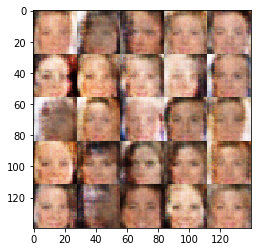

Epoch 1/1... Discriminator loss: 1.4082... Generator loss: 0.7621
Epoch 1/1... Discriminator loss: 1.3986... Generator loss: 0.7562
Epoch 1/1... Discriminator loss: 1.4086... Generator loss: 0.7783
Epoch 1/1... Discriminator loss: 1.3517... Generator loss: 0.7854
Epoch 1/1... Discriminator loss: 1.3507... Generator loss: 0.7684
Epoch 1/1... Discriminator loss: 1.4084... Generator loss: 0.7391
Epoch 1/1... Discriminator loss: 1.4072... Generator loss: 0.7456
Epoch 1/1... Discriminator loss: 1.3637... Generator loss: 0.7633
Epoch 1/1... Discriminator loss: 1.3962... Generator loss: 0.7366
Epoch 1/1... Discriminator loss: 1.3830... Generator loss: 0.7380


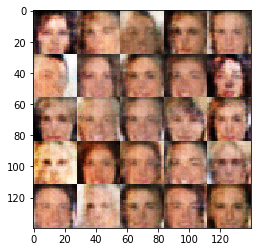

Epoch 1/1... Discriminator loss: 1.3920... Generator loss: 0.7644
Epoch 1/1... Discriminator loss: 1.3064... Generator loss: 0.8088
Epoch 1/1... Discriminator loss: 1.3789... Generator loss: 0.7731
Epoch 1/1... Discriminator loss: 1.4051... Generator loss: 0.7469
Epoch 1/1... Discriminator loss: 1.3795... Generator loss: 0.7451
Epoch 1/1... Discriminator loss: 1.4035... Generator loss: 0.7636
Epoch 1/1... Discriminator loss: 1.4137... Generator loss: 0.7371
Epoch 1/1... Discriminator loss: 1.3750... Generator loss: 0.7604
Epoch 1/1... Discriminator loss: 1.4069... Generator loss: 0.7394
Epoch 1/1... Discriminator loss: 1.3712... Generator loss: 0.7496


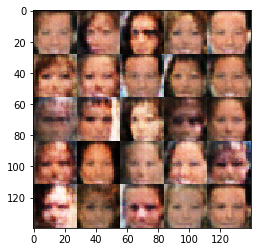

Epoch 1/1... Discriminator loss: 1.3498... Generator loss: 0.7688
Epoch 1/1... Discriminator loss: 1.4071... Generator loss: 0.7494
Epoch 1/1... Discriminator loss: 1.3674... Generator loss: 0.7988
Epoch 1/1... Discriminator loss: 1.3990... Generator loss: 0.7616
Epoch 1/1... Discriminator loss: 1.3518... Generator loss: 0.7758
Epoch 1/1... Discriminator loss: 1.3962... Generator loss: 0.7538
Epoch 1/1... Discriminator loss: 1.3978... Generator loss: 0.7606
Epoch 1/1... Discriminator loss: 1.3778... Generator loss: 0.7448
Epoch 1/1... Discriminator loss: 1.3765... Generator loss: 0.7572
Epoch 1/1... Discriminator loss: 1.3354... Generator loss: 0.8009


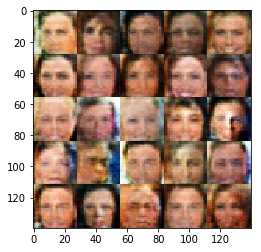

Epoch 1/1... Discriminator loss: 1.3714... Generator loss: 0.7670
Epoch 1/1... Discriminator loss: 1.4237... Generator loss: 0.7414
Epoch 1/1... Discriminator loss: 1.4271... Generator loss: 0.7399
Epoch 1/1... Discriminator loss: 1.3789... Generator loss: 0.7760
Epoch 1/1... Discriminator loss: 1.3799... Generator loss: 0.7851
Epoch 1/1... Discriminator loss: 1.3778... Generator loss: 0.7955
Epoch 1/1... Discriminator loss: 1.3621... Generator loss: 0.7753
Epoch 1/1... Discriminator loss: 1.3486... Generator loss: 0.7840
Epoch 1/1... Discriminator loss: 1.4202... Generator loss: 0.7192
Epoch 1/1... Discriminator loss: 1.3891... Generator loss: 0.7500


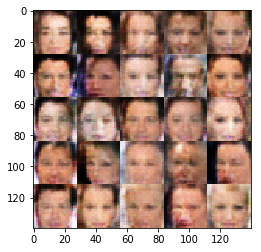

Epoch 1/1... Discriminator loss: 1.3765... Generator loss: 0.7513
Epoch 1/1... Discriminator loss: 1.3934... Generator loss: 0.7670
Epoch 1/1... Discriminator loss: 1.3827... Generator loss: 0.7916
Epoch 1/1... Discriminator loss: 1.4077... Generator loss: 0.7392
Epoch 1/1... Discriminator loss: 1.4063... Generator loss: 0.7699
Epoch 1/1... Discriminator loss: 1.3834... Generator loss: 0.7487
Epoch 1/1... Discriminator loss: 1.3674... Generator loss: 0.7760
Epoch 1/1... Discriminator loss: 1.3331... Generator loss: 0.8019
Epoch 1/1... Discriminator loss: 1.3431... Generator loss: 0.7711
Epoch 1/1... Discriminator loss: 1.3892... Generator loss: 0.7752


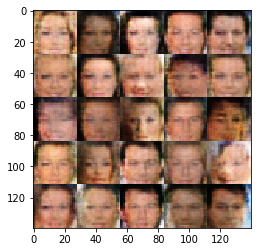

Epoch 1/1... Discriminator loss: 1.3954... Generator loss: 0.7385
Epoch 1/1... Discriminator loss: 1.3586... Generator loss: 0.7628
Epoch 1/1... Discriminator loss: 1.3929... Generator loss: 0.7432
Epoch 1/1... Discriminator loss: 1.3907... Generator loss: 0.7419
Epoch 1/1... Discriminator loss: 1.4192... Generator loss: 0.7114
Epoch 1/1... Discriminator loss: 1.4411... Generator loss: 0.6646
Epoch 1/1... Discriminator loss: 1.4164... Generator loss: 0.7306
Epoch 1/1... Discriminator loss: 1.3742... Generator loss: 0.7530
Epoch 1/1... Discriminator loss: 1.3640... Generator loss: 0.7357
Epoch 1/1... Discriminator loss: 1.4217... Generator loss: 0.6770


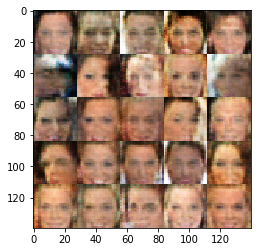

Epoch 1/1... Discriminator loss: 1.4421... Generator loss: 0.7098
Epoch 1/1... Discriminator loss: 1.3739... Generator loss: 0.7639
Epoch 1/1... Discriminator loss: 1.3734... Generator loss: 0.7358
Epoch 1/1... Discriminator loss: 1.3663... Generator loss: 0.7611
Epoch 1/1... Discriminator loss: 1.4968... Generator loss: 0.6432
Epoch 1/1... Discriminator loss: 1.3765... Generator loss: 0.7285
Epoch 1/1... Discriminator loss: 1.3653... Generator loss: 0.7733
Epoch 1/1... Discriminator loss: 1.3795... Generator loss: 0.7661
Epoch 1/1... Discriminator loss: 1.3604... Generator loss: 0.7912
Epoch 1/1... Discriminator loss: 1.3678... Generator loss: 0.7458


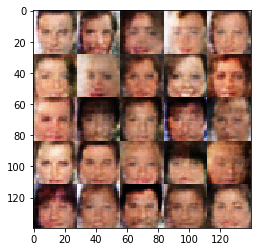

Epoch 1/1... Discriminator loss: 1.3711... Generator loss: 0.7442
Epoch 1/1... Discriminator loss: 1.3689... Generator loss: 0.7447
Epoch 1/1... Discriminator loss: 1.3994... Generator loss: 0.7555
Epoch 1/1... Discriminator loss: 1.4082... Generator loss: 0.7511
Epoch 1/1... Discriminator loss: 1.3843... Generator loss: 0.7521
Epoch 1/1... Discriminator loss: 1.4135... Generator loss: 0.7157
Epoch 1/1... Discriminator loss: 1.3857... Generator loss: 0.7245
Epoch 1/1... Discriminator loss: 1.3784... Generator loss: 0.7592
Epoch 1/1... Discriminator loss: 1.3875... Generator loss: 0.7338
Epoch 1/1... Discriminator loss: 1.3576... Generator loss: 0.7726


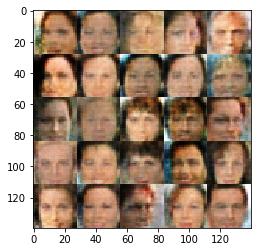

Epoch 1/1... Discriminator loss: 1.4101... Generator loss: 0.7648
Epoch 1/1... Discriminator loss: 1.3703... Generator loss: 0.7374
Epoch 1/1... Discriminator loss: 1.3837... Generator loss: 0.7810
Epoch 1/1... Discriminator loss: 1.4298... Generator loss: 0.6993
Epoch 1/1... Discriminator loss: 1.3901... Generator loss: 0.7611
Epoch 1/1... Discriminator loss: 1.3581... Generator loss: 0.7686
Epoch 1/1... Discriminator loss: 1.4010... Generator loss: 0.7349
Epoch 1/1... Discriminator loss: 1.4236... Generator loss: 0.7236
Epoch 1/1... Discriminator loss: 1.3785... Generator loss: 0.7486
Epoch 1/1... Discriminator loss: 1.3995... Generator loss: 0.7217


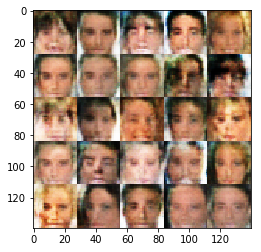

Epoch 1/1... Discriminator loss: 1.4102... Generator loss: 0.7145
Epoch 1/1... Discriminator loss: 1.3832... Generator loss: 0.7669
Epoch 1/1... Discriminator loss: 1.4096... Generator loss: 0.7218
Epoch 1/1... Discriminator loss: 1.4015... Generator loss: 0.7389
Epoch 1/1... Discriminator loss: 1.3924... Generator loss: 0.7574
Epoch 1/1... Discriminator loss: 1.4459... Generator loss: 0.6868
Epoch 1/1... Discriminator loss: 1.4094... Generator loss: 0.7402
Epoch 1/1... Discriminator loss: 1.3786... Generator loss: 0.7214
Epoch 1/1... Discriminator loss: 1.3788... Generator loss: 0.7753
Epoch 1/1... Discriminator loss: 1.3692... Generator loss: 0.7529


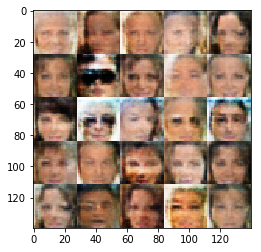

Epoch 1/1... Discriminator loss: 1.4595... Generator loss: 0.6837
Epoch 1/1... Discriminator loss: 1.4216... Generator loss: 0.7124
Epoch 1/1... Discriminator loss: 1.3962... Generator loss: 0.7497
Epoch 1/1... Discriminator loss: 1.3519... Generator loss: 0.8190
Epoch 1/1... Discriminator loss: 1.3806... Generator loss: 0.7182
Epoch 1/1... Discriminator loss: 1.3894... Generator loss: 0.7820
Epoch 1/1... Discriminator loss: 1.3962... Generator loss: 0.7784
Epoch 1/1... Discriminator loss: 1.3661... Generator loss: 0.7695
Epoch 1/1... Discriminator loss: 1.3977... Generator loss: 0.7267
Epoch 1/1... Discriminator loss: 1.3624... Generator loss: 0.7700


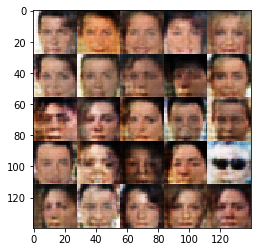

Epoch 1/1... Discriminator loss: 1.3695... Generator loss: 0.7459
Epoch 1/1... Discriminator loss: 1.3754... Generator loss: 0.7371
Epoch 1/1... Discriminator loss: 1.3884... Generator loss: 0.7298
Epoch 1/1... Discriminator loss: 1.4152... Generator loss: 0.7066
Epoch 1/1... Discriminator loss: 1.3519... Generator loss: 0.7383
Epoch 1/1... Discriminator loss: 1.3839... Generator loss: 0.7182
Epoch 1/1... Discriminator loss: 1.3828... Generator loss: 0.7712
Epoch 1/1... Discriminator loss: 1.3710... Generator loss: 0.7421
Epoch 1/1... Discriminator loss: 1.3634... Generator loss: 0.7746
Epoch 1/1... Discriminator loss: 1.3897... Generator loss: 0.7426


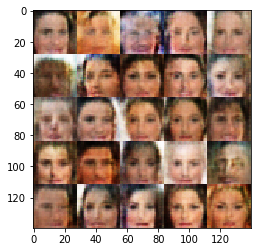

Epoch 1/1... Discriminator loss: 1.3794... Generator loss: 0.7375
Epoch 1/1... Discriminator loss: 1.3653... Generator loss: 0.7480
Epoch 1/1... Discriminator loss: 1.4077... Generator loss: 0.7669
Epoch 1/1... Discriminator loss: 1.4030... Generator loss: 0.7108
Epoch 1/1... Discriminator loss: 1.4089... Generator loss: 0.7342
Epoch 1/1... Discriminator loss: 1.4277... Generator loss: 0.6164
Epoch 1/1... Discriminator loss: 1.4284... Generator loss: 0.7712
Epoch 1/1... Discriminator loss: 1.3458... Generator loss: 0.8131
Epoch 1/1... Discriminator loss: 1.3954... Generator loss: 0.7561
Epoch 1/1... Discriminator loss: 1.3869... Generator loss: 0.7560


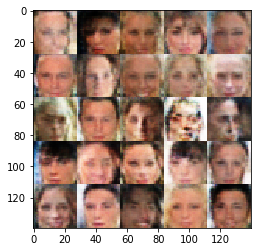

Epoch 1/1... Discriminator loss: 1.3632... Generator loss: 0.7833
Epoch 1/1... Discriminator loss: 1.4181... Generator loss: 0.6894
Epoch 1/1... Discriminator loss: 1.4164... Generator loss: 0.7139
Epoch 1/1... Discriminator loss: 1.3907... Generator loss: 0.7320
Epoch 1/1... Discriminator loss: 1.3891... Generator loss: 0.7400
Epoch 1/1... Discriminator loss: 1.3792... Generator loss: 0.7314
Epoch 1/1... Discriminator loss: 1.3884... Generator loss: 0.7102
Epoch 1/1... Discriminator loss: 1.3741... Generator loss: 0.7626
Epoch 1/1... Discriminator loss: 1.4075... Generator loss: 0.7309
Epoch 1/1... Discriminator loss: 1.3459... Generator loss: 0.7481


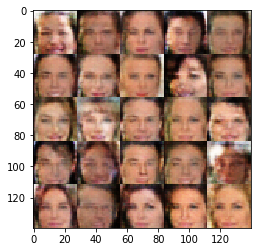

Epoch 1/1... Discriminator loss: 1.3574... Generator loss: 0.7880
Epoch 1/1... Discriminator loss: 1.3477... Generator loss: 0.7706
Epoch 1/1... Discriminator loss: 1.4164... Generator loss: 0.6978
Epoch 1/1... Discriminator loss: 1.3578... Generator loss: 0.7441
Epoch 1/1... Discriminator loss: 1.3572... Generator loss: 0.7751
Epoch 1/1... Discriminator loss: 1.3758... Generator loss: 0.7186
Epoch 1/1... Discriminator loss: 1.3830... Generator loss: 0.7324
Epoch 1/1... Discriminator loss: 1.3724... Generator loss: 0.8145
Epoch 1/1... Discriminator loss: 1.3577... Generator loss: 0.7241
Epoch 1/1... Discriminator loss: 1.4321... Generator loss: 0.7024


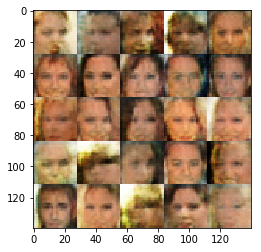

Epoch 1/1... Discriminator loss: 1.3918... Generator loss: 0.7363
Epoch 1/1... Discriminator loss: 1.3471... Generator loss: 0.7704
Epoch 1/1... Discriminator loss: 1.3614... Generator loss: 0.7525
Epoch 1/1... Discriminator loss: 1.3497... Generator loss: 0.7298
Epoch 1/1... Discriminator loss: 1.3909... Generator loss: 0.7257
Epoch 1/1... Discriminator loss: 1.3609... Generator loss: 0.7900
Epoch 1/1... Discriminator loss: 1.4157... Generator loss: 0.7285
Epoch 1/1... Discriminator loss: 1.3915... Generator loss: 0.7344
Epoch 1/1... Discriminator loss: 1.3807... Generator loss: 0.7355
Epoch 1/1... Discriminator loss: 1.4083... Generator loss: 0.7700


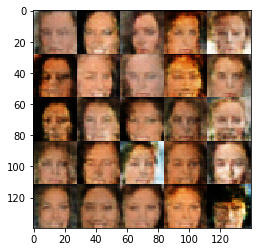

Epoch 1/1... Discriminator loss: 1.4128... Generator loss: 0.7200
Epoch 1/1... Discriminator loss: 1.3637... Generator loss: 0.7837
Epoch 1/1... Discriminator loss: 1.4869... Generator loss: 0.6427
Epoch 1/1... Discriminator loss: 1.3728... Generator loss: 0.7451
Epoch 1/1... Discriminator loss: 1.3597... Generator loss: 0.7677
Epoch 1/1... Discriminator loss: 1.3975... Generator loss: 0.7463
Epoch 1/1... Discriminator loss: 1.3875... Generator loss: 0.7650
Epoch 1/1... Discriminator loss: 1.3846... Generator loss: 0.7249
Epoch 1/1... Discriminator loss: 1.3482... Generator loss: 0.7691
Epoch 1/1... Discriminator loss: 1.3781... Generator loss: 0.7249


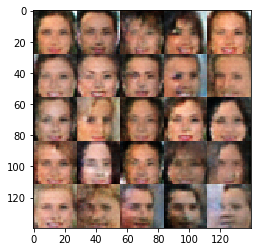

Epoch 1/1... Discriminator loss: 1.3911... Generator loss: 0.7185
Epoch 1/1... Discriminator loss: 1.4261... Generator loss: 0.7205
Epoch 1/1... Discriminator loss: 1.3659... Generator loss: 0.7267
Epoch 1/1... Discriminator loss: 1.3205... Generator loss: 0.7860
Epoch 1/1... Discriminator loss: 1.3440... Generator loss: 0.7820
Epoch 1/1... Discriminator loss: 1.3746... Generator loss: 0.7495


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.